---

## Working Code

In [1]:
%matplotlib inline

In [2]:
# import basic packages
import os
import math

#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

get_ipython().magic('matplotlib inline')

In [9]:
class LaneDetectionHelper(object):
    """class to define lane detector"""
    def __init__(self,params):
        """
        initializing lane detector with default parameters
        """
        # size of kernel for gaussian blur algorithm
        self.kernel_size = params.get('kernel_size', 5)
        # canny edge detection low threshold
        self.low_threshold = params.get('low_threshold', 50)
        # canny edge detection high threshold
        self.high_threshold = params.get('high_threshold', 150)
        # distance resolution in pixels of the Hough grid
        self.rho = params.get('rho', 1)
        # angular resolution in radians of the Hough grid
        self.theta = params.get('theta', np.pi/180)
        # minimum number of votes (intersections in Hough grid cell)
        self.threshold = params.get('threshold', 1)
        # minimum number of pixels making up a line
        self.min_line_len = params.get('min_line_len', 10)
        # maximum gap in pixels between connectable line segments
        self.max_line_gap = params.get('max_line_gap', 1)
        # thickness of detected line
        self.line_thickness = params.get('line_thickness', 5)
        # color of detected line
        self.line_color = params.get('line_color', [255, 255, 255])
        # color of detected line
        self.line_slope_threshold = params.get('line_slope_threshold', [0.5, 1])
        # color of region of interest
        self.mask_color = params.get('mask_color', [255, 0, 0])
        # bottom offset for region of interest
        self.bottom_offset = params.get('bottom_offset', 55)
        # show just the lines detected without extrapolation
        self.extrapolate_flag = params.get('extrapolate_flag', True)
        # show the region of interest
        self.show_mask_flag = params.get('show_mask_flag', False)

    def grayscale(self, img):
        """Applies the Grayscale transform
        This will return an image with only one color channel
        but NOTE: to see the returned image as grayscale
        (assuming your grayscaled image is called 'gray')
        you should call plt.imshow(gray, cmap='gray')"""
        #return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Or use BGR2GRAY if you read an image with cv2.imread()
        return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    def canny(self, img, low_threshold, high_threshold):
        """Applies the Canny transform"""
        return cv2.Canny(img, low_threshold, high_threshold)

    def gaussian_blur(self, img, kernel_size):
        """Applies a Gaussian Noise kernel"""
        return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

    def region_of_interest(self, img, vertices):
        """
        Applies an image mask.

        Only keeps the region of the image defined by the polygon
        formed from `vertices`. The rest of the image is set to black.
        """
        # defining a blank mask to start with
        #mask = np.zeros(img.shape, dtype=np.uint8)
        mask = np.zeros_like(img)

        # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
        if len(img.shape) > 2:
            channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
            ignore_mask_color = (255,) * channel_count
        else:
            ignore_mask_color = 255

        # filling pixels inside the polygon defined by "vertices" with the fill color
        cv2.fillPoly(mask, vertices, ignore_mask_color)

        # returning the image only where mask pixels are nonzero
        masked_image = cv2.bitwise_and(img, mask)
        return masked_image

    def hough_lines(self, img, rho, theta, threshold, min_line_len, max_line_gap, vertices):
        """
        `img` should be the output of a Canny transform.

        Returns an image with hough lines drawn.
        """
        lines = cv2.HoughLinesP(
            img,
            rho,
            theta,
            threshold,
            np.array([]),
            minLineLength=min_line_len,
            maxLineGap=max_line_gap)

        line_img = np.zeros((*img.shape, 3), dtype=np.uint8)

        if self.show_mask_flag:
            cv2.fillPoly(line_img, vertices, self.mask_color)

        self.draw_lines(line_img, lines, vertices)
        return line_img

    def draw_lines(self, img, lines, vertices):
        """
        NOTE: this is the function you might want to use as a starting point once you want to
        average/extrapolate the line segments you detect to map out the full
        extent of the lane (going from the result shown in raw-lines-example.mp4
        to that shown in P1_example.mp4).

        Think about things like separating line segments by their
        slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
        line vs. the right line.  Then, you can average the position of each of
        the lines and extrapolate to the top and bottom of the lane.

        This function draws `lines` with `color` and `thickness`.
        Lines are drawn on the image inplace (mutates the image).
        If you want to make the lines semi-transparent, think about combining
        this function with the weighted_img() function below
        """

        left_lines = []
        right_lines = []
        threshold = self.line_slope_threshold

        for line in lines:
            for x1, y1, x2, y2 in line:
                slope = ((y2-y1)/(x2-x1)) if (x2-x1) != 0 else 0

                if self.extrapolate_flag:
                    if (
                            (threshold[0] < abs(slope) < threshold[1]) and
                            np.sign(slope) < 0 and
                            not np.isnan(slope) and
                            not np.isinf(slope)
                    ):
                        right_lines.append(line)
                    if (
                            (threshold[0] < abs(slope) < threshold[1]) and
                            np.sign(slope) > 0 and
                            not np.isnan(slope) and
                            not np.isinf(slope)
                    ):
                        left_lines.append(line)
                else:
                    cv2.line(img, (x1, y1), (x2, y2), self.line_color, self.line_thickness)


        if self.extrapolate_flag:
            if left_lines:
                self.draw_left_line(img, left_lines, vertices)

            if right_lines:
                self.draw_right_line(img, right_lines, vertices)

    def draw_left_line(self, img, lines, vertices):
        """
        draws left line of the detected lane
        """
        # get the y coordinate of beginning of all lines
        all_y1 = np.array([line[0][1] for line in lines])

        # with given set of lines find straight line that is the best approximation
        # of the given set of data. more accurate way of finding the line of best
        # fit is the least square method
        #m, b = self.compute_least_squares(lines)
        X = np.append(
            np.array([line[0][0] for line in lines]),
            np.array([line[0][2] for line in lines])
        )
        Y = np.append(
            np.array([line[0][1] for line in lines]),
            np.array([line[0][3] for line in lines])
        )
        m, b = np.polyfit(X, Y, 1)

        y1 = min(np.min(all_y1), int(np.mean(all_y1)))
        x1 = int((y1 - b) / m)
        y2 = vertices[0][3][1]
        x2 = int((y2 - b) / m)

        cv2.line(img, (x1, y1), (x2, y2), self.line_color, self.line_thickness)

    def draw_right_line(self, img, lines, vertices):
        """
        draws right line of the detected lane
        """
        # get the y coordinate of beginning of all lines
        all_y2 = np.array([line[0][3] for line in lines])

        # with given set of lines find straight line that is the best approximation
        # of the given set of data. more accurate way of finding the line of best
        # fit is the least square method
        #m, b = self.compute_least_squares(lines)
        X = np.append(
            np.array([line[0][0] for line in lines]),
            np.array([line[0][2] for line in lines])
        )
        Y = np.append(
            np.array([line[0][1] for line in lines]),
            np.array([line[0][3] for line in lines])
        )
        m, b = np.polyfit(X, Y, 1)

        y2 = min(np.min(all_y2), int(np.mean(all_y2)))
        x2 = int((y2 - b) / m)
        y1 = vertices[0][0][1]
        x1 = int((y1 - b) / m)

        cv2.line(img, (x1, y1), (x2, y2), self.line_color, self.line_thickness)

    @staticmethod
    def compute_least_squares(lines):
        for line in lines:
            X1 = np.array([line[0][0] for line in lines])
            Y1 = np.array([line[0][1] for line in lines])
            X2 = np.array([line[0][2] for line in lines])
            Y2 = np.array([line[0][3] for line in lines])

        X = np.append(X1, X2)
        Y = np.append(Y1, Y2)
        mean_X = np.mean(X)
        mean_Y = np.mean(Y)

        slope = np.dot((X-mean_X), (Y-mean_Y))/ np.sum((X-mean_X)**2)
        y_intercept = mean_Y - slope * mean_X

        return slope, y_intercept

    def weighted_img(self, initial_img, img, alpha=0.8, beta=1., gamma=0.):
        """
        `img` is the output of the hough_lines(), An image with lines drawn on it.
        Should be a blank image (all black) with lines drawn on it.

        `initial_img` should be the image before any processing.

        The result image is computed as follows:

        initial_img * alpha + img * beta + gamma
        NOTE: initial_img and img must be the same shape!
        """
        return cv2.addWeighted(initial_img, alpha, img, beta, gamma)

#     def lane_detection_pipeline(self, image):
#         """
#         main method or pipeline to detect lane given an image
#         """
#         # convert image from RGB to gray
#         grayed = self.grayscale(image)
#         # apply gaussian filter to remove the sharp edges
#         blurred_gray = self.gaussian_blur(grayed, self.kernel_size)
#         # apply canny edge detection algorithm
#         edges = self.canny(blurred_gray, self.low_threshold, self.high_threshold)
        
#         # chosing four sided polygon to mask instead of a triangle
#         imshape = image.shape
#         img_height = imshape[0]
#         img_width = imshape[1]

#         # [bottom-left, top-left, top-right, bottom-right]
#         vertice_weights = np.array([(1, 1), (0.448, 0.575), (0.516, 0.575), (0.948, 1)])
#         vertices = np.array([
#             [
#                 (self.bottom_offset, img_height) * vertice_weights[0],
#                 (img_width, img_height) * vertice_weights[1],
#                 (img_width, img_height) * vertice_weights[2],
#                 (img_width, img_height) * vertice_weights[3]
#             ]
#         ], dtype=np.int32)

#         masked_edges = self.region_of_interest(edges, vertices)

#         # applying hough transformation
#         hough_img = self.hough_lines(
#             masked_edges,
#             self.rho,
#             self.theta,
#             self.threshold,
#             self.min_line_len,
#             self.max_line_gap,
#             vertices)

#         result = self.weighted_img(image, hough_img, alpha=1., beta=0.8, gamma=0.)

#         return result

In [10]:
class LaneDetectionPipeline(object):
    """
    utility class to call lane detection pipeline given image or video
    """

    def process_image_dir(self, in_dir, save_image_flag=False, out_dir="./test_images/results"):
        """
        process all images in a directory
        """
        src_dir = os.listdir(in_dir)

        if save_image_flag:
            if not os.path.exists(out_dir):
                os.mkdir(out_dir)
        
        cntr_image = 1

        for img in src_dir:
            image = mpimg.imread(in_dir + img)
            result = self.process_image(image)

            plt.figure(figsize=(15, 10))
            plt.title(img)
            plt.grid(True)
            plt.imshow(result)
            plt.show()
            
            if save_image_flag:
                out_img = out_dir + img
                mpimg.imsave(out_img, result)
                print('successfully detected lines: in = {} and out = {}'.format(img, out_img))

            cntr_image += 1

    def process_image(self, image):
        """
        process image to find lines
        """

        params = {
            'kernel_size': 5,
            'low_threshold': 50,
            'high_threshold': 150,
            'rho': 1,
            'theta': np.pi/180,
            'threshold': 1,
            'min_line_len': 10,
            'max_line_gap': 1,
            'line_thickness': 8,
            'line_color': [255, 0, 0],
            'line_slope_threshold': [0.45, 1],
            'mask_color': (255, 0, 0),
            'extrapolate_flag': True,
            'show_mask_flag': False,
            'bottom_offset': 55
        }

        result = self.lane_detection_pipeline(image, params)
        
        return result

    def process_video(self, in_file, out_file):
        """
        process image to find lines
        """
        in_video = VideoFileClip(in_file)
        out_video = in_video.fl_image(self.process_image)
        out_video.write_videofile(out_file, audio=False)

        
    def lane_detection_pipeline(self, image, params):
        """
        main method or pipeline to detect lane given an image
        """
        
        # lane detection pipeline
        ldp = LaneDetectionHelper(params)
        
        # convert image from RGB to gray
        grayed = ldp.grayscale(image)
        # apply gaussian filter to remove the sharp edges
        blurred_gray = ldp.gaussian_blur(grayed, ldp.kernel_size)
        # apply canny edge detection algorithm
        edges = ldp.canny(blurred_gray, ldp.low_threshold, ldp.high_threshold)
        
        # chosing four sided polygon to mask instead of a triangle
        imshape = image.shape
        img_height = imshape[0]
        img_width = imshape[1]

        # [bottom-left, top-left, top-right, bottom-right]
        vertice_weights = np.array([(1, 1), (0.448, 0.575), (0.516, 0.575), (0.948, 1)])
        vertices = np.array([
            [
                (ldp.bottom_offset, img_height) * vertice_weights[0],
                (img_width, img_height) * vertice_weights[1],
                (img_width, img_height) * vertice_weights[2],
                (img_width, img_height) * vertice_weights[3]
            ]
        ], dtype=np.int32)

        masked_edges = ldp.region_of_interest(edges, vertices)

        # applying hough transformation
        hough_img = ldp.hough_lines(
            masked_edges,
            ldp.rho,
            ldp.theta,
            ldp.threshold,
            ldp.min_line_len,
            ldp.max_line_gap,
            vertices)

        result = ldp.weighted_img(image, hough_img, alpha=1., beta=0.8, gamma=0.)

        return result

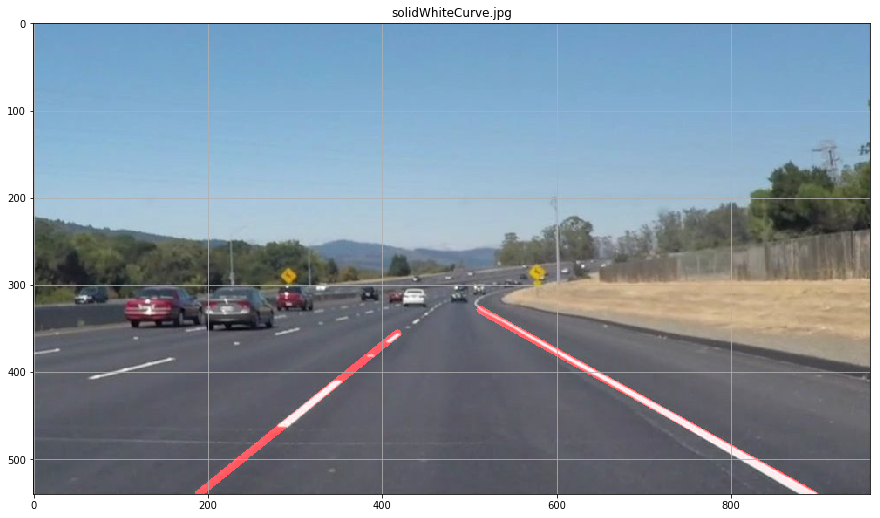

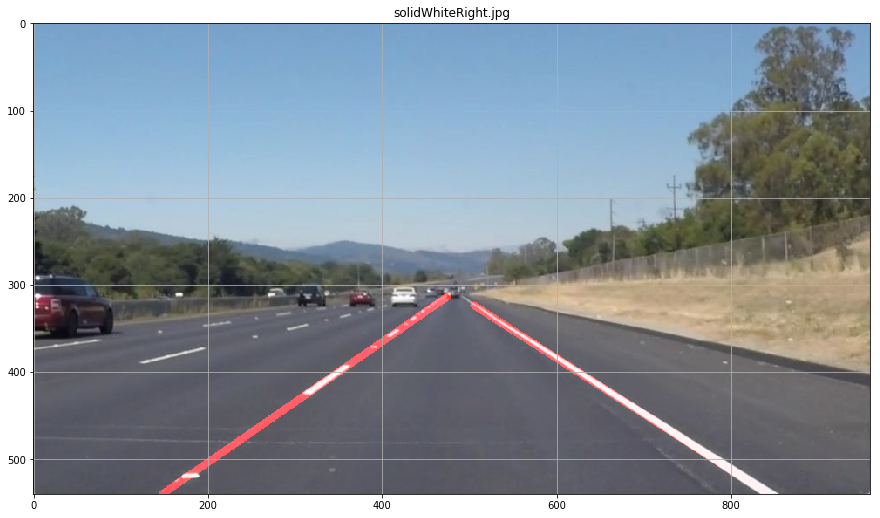

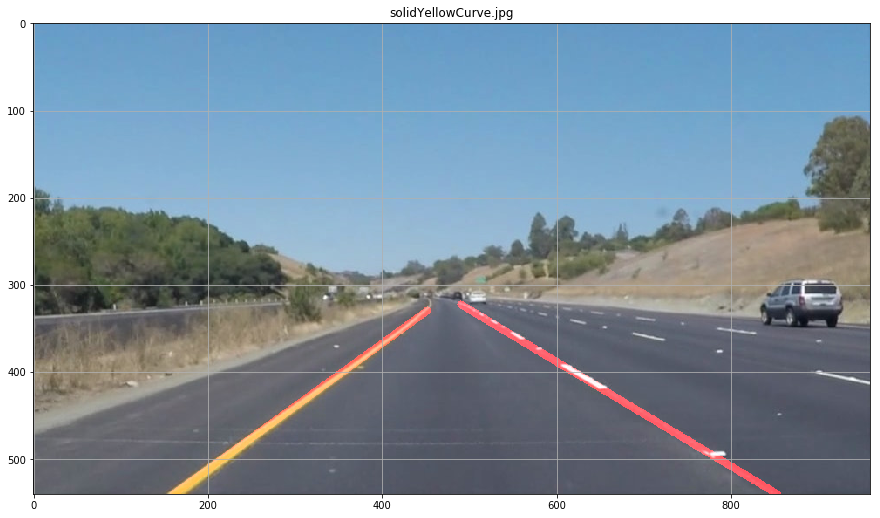

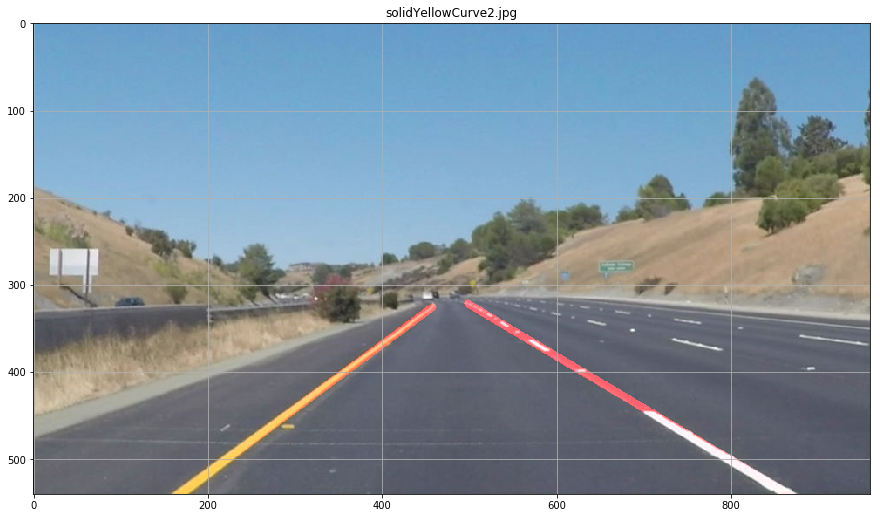

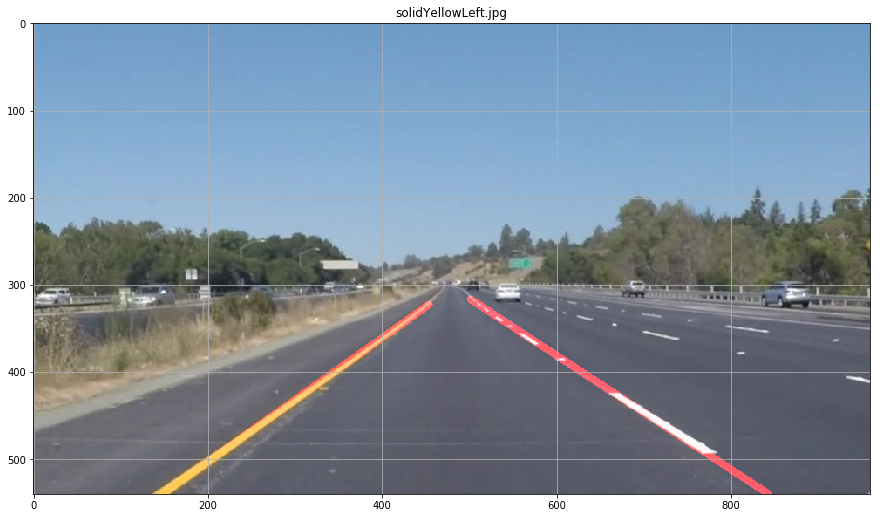

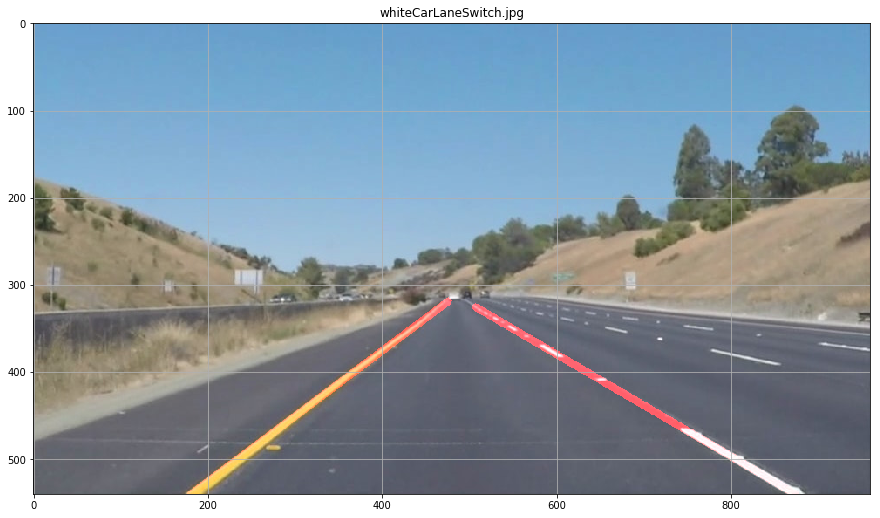

In [11]:
image_lane_detector = LaneDetectionPipeline()
image_lane_detector.process_image_dir('test_images/', False)

In [6]:
video_lane_detector = LaneDetectionPipeline()
%time video_lane_detector.process_video("./test_videos/solidWhiteRight.mp4", "./test_videos/results/out.solidWhiteRight.mp4")

[MoviePy] >>>> Building video ./test_videos/results/out.solidWhiteRight.mp4
[MoviePy] Writing video ./test_videos/results/out.solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:16<00:00, 10.74it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_videos/results/out.solidWhiteRight.mp4 

CPU times: user 3.14 s, sys: 122 ms, total: 3.27 s
Wall time: 19.5 s


In [7]:
video_lane_detector = LaneDetectionPipeline()
%time video_lane_detector.process_video("./test_videos/solidYellowLeft.mp4", "./test_videos/results/out.solidYellowLeft.mp4")

[MoviePy] >>>> Building video ./test_videos/results/out.solidYellowLeft.mp4
[MoviePy] Writing video ./test_videos/results/out.solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:54<00:00, 12.54it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_videos/results/out.solidYellowLeft.mp4 

CPU times: user 9.34 s, sys: 311 ms, total: 9.65 s
Wall time: 56.7 s


In [8]:
video_lane_detector = LaneDetectionPipeline()
%time video_lane_detector.process_video("./test_videos/challenge.mp4", "./test_videos/results/out.challenge.mp4")

[MoviePy] >>>> Building video ./test_videos/results/out.challenge.mp4
[MoviePy] Writing video ./test_videos/results/out.challenge.mp4


100%|██████████| 251/251 [00:43<00:00,  6.62it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_videos/results/out.challenge.mp4 

CPU times: user 5.79 s, sys: 286 ms, total: 6.08 s
Wall time: 48.5 s
